# Line search methods


Given a minimisation problem of an objective function $f(x): R^n -> R$, a line search method is a method in the form:

$ x_{k+1} = x_k + \alpha p_k$

where $x_k$ is the current iteration of the solution, $p_k$ is the search direction and $alpha_k$ is the step length. 

The step lenght is calculated by solving a one-dimension minimisation problem. Let's consider the following case. We have computed the solution at iteration $k$ (namely $x_k$) and the search direction $p_k$. However we don't know how long to *walk* on this direction to minimise the objective function $f$. We need to minimise the following problem:

$\phi(\alpha) = f(x_k + p_k) ;quad for \alpha > 0$

If the objective function is quadratic, it can be trivially be solved. However, generally this problem is too expensive to be solved exactly. We can provide an $\alpha$ for a sufficient decrease of $f$ using the backtracking algorithm.

This notebook implements various line searh methods. Each method refers to a global variable `func` which implements the objective function as a class. To examples are given:

1. A generic quadratic function
1. The rosenbrock function

Depending on the method, the class is supposed to have the methods to evaluate the function, its gradient and the hessian.

In [57]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt

In [15]:
# TODO make a funnction class model to implement and override

class rosenbrock:
    def __init__(self, a, b):
        self.a = a
        self.b = b

    def evaluate(self, x):
        '''
        Rosenbrock function R^n -> R
        '''
        return (self.a - x[0])**2 + (x[1] - x[0]**2)*self.b

    def evaluate_gradient(self, x):
        grad_0 = -4*self.b*x[0]*(x[1] - x[0]**2)+ 2*(x[0] - self.a)
        grad_1 =  2*self.b*(x[1] - x[0]**2) 
        return np.array([grad_0, grad_1])

sol = np.array([1, 1]) # the minimiser
func  = rosenbrock(a=1, b=100)
print('Function evaluation: ', func.evaluate(sol))
print('Gradient evaluation: ', func.evaluate_gradient(sol))

Function evaluation:  0
Gradient evaluation:  [0 0]


In [21]:
class generic_function:
    def __init__(self, a):
        self.a = a

    def evaluate(self, x):
        return x[0]**2 + self.a * x[1]**2

    def evaluate_gradient(self, x):
        return np.array( [2*x[0], self.a *2* x[1] ] )

    def evaluate_hessian(self, x):
        return np.array([ [2, 0], [0, self.a *2]])

sol = np.array([0, 0]) # the minimiser
func = generic_function(a=10)
print('Function evaluation: ', func.evaluate(sol))
print('Gradient evaluation: ', func.evaluate_gradient(sol))

Function evaluation:  0
Gradient evaluation:  [0 0]


# Steepest Descent

The simplest line search method is steepest descent. In this case the matrix $B$ is the identity matrix and the direction $p$ is the negative gradient of the function.

In [46]:
def  backtracking(x, p, c=0.7, rho=0.6, alpha=1)->int:
    global func
    while func.evaluate(x + alpha*p) >= func.evaluate(x) + c*alpha*np.dot(func.evaluate_gradient(x), p):
        alpha *= rho
    return alpha

def steepest_descent(x_init, eps=10**-8, max_iter = 100):
    global func
    x_k = x_init
    grad = func.evaluate_gradient(x_k)
    iter = 0
    while linalg.norm(grad) > eps and iter < max_iter: 
        p_k = -grad
        alpha = backtracking(x_k, p_k) # todo
        x_k = x_k + alpha*p_k
        grad = func.evaluate_gradient(x_k)
        iter += 1
    return x_k, iter

in_point = np.random.rand(2)
num_x = steepest_descent(in_point)
print('Numerica solution: ', num_x)

Numerica solution:  (array([3.94003753e-09, 2.74704312e-10]), 66)


# Convergence ratio of steepest descent

Any gener quadatic function can be writtein as:

$$f(x) = \frac{1}{2}x^T Q x^T - b^ x$$

Hence the generic function $f(x) = x_1 + a x_2$:

$$f(x) = x^T \begin{bmatrix}1 & 0 \\ 0 & a\end{bmatrix} x $$

It can be proved that the convergence ratio of steepest depeds on the condition number of $Q$.

Text(0, 0.5, 'Iterations to convergence')

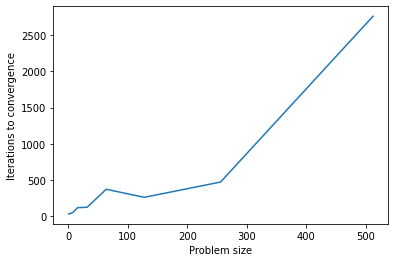

In [61]:
in_point = np.random.rand(2)

iter_array = []
for i in range(10):
    func = generic_function(a=2**i)
    in_point = np.random.rand(2)
    num_x, iter = steepest_descent(in_point, max_iter=5000)
    iter_array.append(iter)
    

plt.plot([2**i for i in range(10)], iter_array)
plt.xlabel('Problem size')
plt.ylabel('Iterations to convergence')

# Newton method

The Newton method employs second order information to speed up the convergence ratio of the steepest descent. The search direction $p_k$ is chosen as follows:

$p_k = - H_k^{-1} g_k$

where $H$ is the Hessian of the objective function and $g$ its gradient.

In [45]:
def newton_method(x_init, eps=10**-3, max_iter = 100):
    x_k = x_init
    grad = func.evaluate_gradient(x_k)
    hessian = func.evaluate_hessian(x_k)
    iter = 0
    while linalg.norm(grad) > eps and iter < max_iter: 
        # print(x_k)
        x_k = x_k - linalg.inv(hessian) @ grad
        grad = func.evaluate_gradient(x_k)
        hessian = func.evaluate_hessian(x_k)
        iter += 1
    return x_k

in_point = np.random.rand(2)
num_x = newton_method(in_point)
print(num_x)

1
[0. 0.]


# Convergence ratio of Newton method

Note that Newton methods converges exactly in one step for quadratic functions. This can be easiy be seen by solving the optimization problem using the generic function (with any variable `a`), it takes one iteration. For more general problems, the Newton method is not guarantee to converge. The search direction $p = -H^{-1} g$ is a descent direction only if $H$ is positive definite, which is, only if the starting point $x_0$ is sufficiently close to the minimiser.

The rate of convergence of Newton method 